In [17]:
import os
# Force TensorFlow/Keras to use CPU only to avoid MPS float64 errors
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
try:
    tf.config.set_visible_devices([], 'GPU')
    print("GPU Disabled. Running on CPU to support float64.")
except:
    pass

GPU Disabled. Running on CPU to support float64.


In [18]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tslearn.datasets import UCR_UEA_datasets
from tslearn.shapelets import LearningShapelets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.preprocessing import LabelEncoder

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- CONFIGURATION ---
DATASET_NAME = "ECG200"  # Change this to "GunPoint", "Coffee", "ECG200", etc.
SCALER = "minmax"          # "minmax", "zscore", or None
N_TEST_SUBSAMPLE = None    # Set to None for full test set, or int (e.g., 50)
SUBSAMPLE_SEED = 42


# Model Hyperparameters
K_SHAPELETS = 8           # Number of shapelets
SHAPELET_LEN_RATIO = 0.3   # Shapelet length as a fraction of time series length
ITERATIONS = 800
LR = 0.01
LAMBDA_W = 0.01            # Weight decay for linear layer
OPTIMIZER_NAME = 'AdamW'   # 'SGD' or 'AdamW'

print(f"Configuration set for dataset: {DATASET_NAME}")

Configuration set for dataset: ECG200


In [19]:
# CELL 2 — Data loading + preprocessing (+ optional test subsample)
# (Helper functions from your provided code)

def standardize_ucr_name(name):
    # Simple helper to fix common naming issues if needed, otherwise pass through
    return name

def load_ucr(dataset_name="GunPoint", scaler="minmax"):
    dataset_name = standardize_ucr_name(dataset_name)
    ucr = UCR_UEA_datasets()
    # Note: explicit load might be needed for some versions of tslearn
    try:
        X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)
    except:
        print(f"Dataset {dataset_name} not found in cache, downloading...")
        X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)

    if X_train is None:
        raise ValueError(f"Could not load dataset: {dataset_name}")

    if scaler == "minmax":
        sc = TimeSeriesScalerMinMax()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    elif scaler == "zscore":
        sc = TimeSeriesScalerMeanVariance()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    elif scaler in (None, "none"):
        pass
    else:
        raise ValueError(f"Unknown scaler={scaler}")

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    meta = {
        "dataset": dataset_name,
        "n_train": X_train.shape[0],
        "n_test": X_test.shape[0],
        "ts_len": X_train.shape[1],
        "n_channels": X_train.shape[2],
        "n_classes": len(np.unique(y_train_enc)),
        "classes": list(le.classes_),
        "label_encoder": le,
        "scaler": scaler,
    }
    return X_train, y_train_enc, X_test, y_test_enc, meta


def subsample_test_set(X_test, y_test, n_test_subsample=10, subsample_seed=0):
    if n_test_subsample is None or n_test_subsample >= len(y_test):
        meta_sub = {
            "n_test_full": len(y_test),
            "test_subsample_indices": list(range(len(y_test))),
        }
        return X_test, y_test, meta_sub

    rng = np.random.default_rng(subsample_seed)
    classes = np.unique(y_test)

    per_class = max(1, n_test_subsample // len(classes))
    chosen = []
    for c in classes:
        idx = np.where(y_test == c)[0]
        take = min(per_class, len(idx))
        chosen.extend(rng.choice(idx, size=take, replace=False).tolist())

    chosen = np.array(sorted(set(chosen)), dtype=int)
    if len(chosen) < n_test_subsample:
        remaining = np.setdiff1d(np.arange(len(y_test)), chosen, assume_unique=False)
        extra = rng.choice(
            remaining, size=n_test_subsample - len(chosen), replace=False
        )
        chosen = np.concatenate([chosen, extra])

    rng.shuffle(chosen)

    meta_sub = {"n_test_full": len(y_test), "test_subsample_indices": chosen.tolist()}
    return X_test[chosen], y_test[chosen], meta_sub

In [20]:
# CELL 2b — Use data functions immediately

# Load Data
X_train, y_train, X_test, y_test, meta = load_ucr(DATASET_NAME, scaler=SCALER)

# Subsample Test Set (if configured)
X_test, y_test, meta_sub = subsample_test_set(
    X_test, y_test, n_test_subsample=N_TEST_SUBSAMPLE, subsample_seed=SUBSAMPLE_SEED
)

# Merge Meta Info
meta["n_test_full"] = meta_sub["n_test_full"]
meta["n_test"] = len(y_test)
meta["test_subsample_indices"] = meta_sub["test_subsample_indices"]

# Calculate Dynamic Shapelet Length (e.g., 30% of TS length)
# We ensure it is at least 1
calculated_shapelet_len = max(1, int(meta['ts_len'] * SHAPELET_LEN_RATIO))

print("=== Dataset meta ===")
for k in ["dataset", "n_train", "n_test", "ts_len", "n_classes", "scaler"]:
    print(f"{k}: {meta[k]}")
print(f"Shapelet Params: K={K_SHAPELETS}, L={calculated_shapelet_len} (Ratio: {SHAPELET_LEN_RATIO})")

=== Dataset meta ===
dataset: ECG200
n_train: 100
n_test: 100
ts_len: 96
n_classes: 2
scaler: minmax
Shapelet Params: K=8, L=28 (Ratio: 0.3)


In [21]:
from tslearn.clustering import TimeSeriesKMeans

# 1. Define Model Class (Same as before)
class LearningShapeletsModel(nn.Module):
    def __init__(self, n_shapelets, shapelet_length, input_length, num_classes):
        super(LearningShapeletsModel, self).__init__()
        self.n_shapelets = n_shapelets
        self.shapelet_length = shapelet_length
        self.alpha = -100.0
        self.shapelets = nn.Parameter(torch.randn(n_shapelets, shapelet_length))
        self.linear = nn.Linear(n_shapelets, num_classes)
        
    def forward(self, x):
        x_unfolded = x.unfold(1, self.shapelet_length, 1)
        x_expanded = x_unfolded.unsqueeze(2)
        s_expanded = self.shapelets.view(1, 1, self.n_shapelets, self.shapelet_length)
        dist_sq = torch.sum((x_expanded - s_expanded) ** 2, dim=3) / self.shapelet_length 
        weights = torch.exp(self.alpha * dist_sq)
        soft_min_dist = torch.sum(dist_sq * weights, dim=1) / (torch.sum(weights, dim=1) + 1e-8)
        output = self.linear(soft_min_dist)
        return output, soft_min_dist

    def initialize_kmeans(self, X_train):
        print(f"Initializing {self.n_shapelets} shapelets via K-Means...")
        windows = []
        # Optimization: Don't take ALL windows if TS is huge, sample them
        limit_windows = 10000 
        
        for i in range(min(X_train.shape[0], 200)): # Limit to 200 samples for init speed
            for j in range(X_train.shape[1] - self.shapelet_length + 1):
                windows.append(X_train[i, j:j+self.shapelet_length])
        
        windows = np.array(windows)
        if len(windows) > limit_windows:
            idx = np.random.choice(len(windows), limit_windows, replace=False)
            windows = windows[idx]
            
        kmeans = TimeSeriesKMeans(n_clusters=self.n_shapelets, metric="euclidean", max_iter=50)
        kmeans.fit(windows)
        self.shapelets.data = torch.tensor(kmeans.cluster_centers_.squeeze(), dtype=torch.float32)


In [22]:
# import matplotlib.pyplot as plt
# from tslearn.shapelets import LearningShapelets

# # -----------------------------------------------------------------------------
# # 1. CONFIGURATION
# # -----------------------------------------------------------------------------
# # Model Hyperparameters
# K_SHAPELETS = 5           # Number of shapelets
# SHAPELET_LEN_RATIO = 0.3   # Shapelet length as a fraction of time series length
# ITERATIONS = 800
# LR = 0.01
# LAMBDA_W = 0.01            # Weight decay for linear layer
# OPTIMIZER_NAME = 'AdamW'   # 'SGD' or 'AdamW'

param_dict = {
    'K_SHAPELETS': K_SHAPELETS,
    'calculated_shapelet_len': calculated_shapelet_len,
    'meta': meta,
    'LAMBDA_W': LAMBDA_W,
    'LR': LR,
    'OPTIMIZER_NAME': OPTIMIZER_NAME,
    'ITERATIONS': ITERATIONS
}


In [23]:
def pt_model_data(X,y):
    X_sq = X.squeeze()
    if X_sq.ndim == 1: X_sq = X_sq.unsqueeze(1)
    
    X_tensor = torch.tensor(X_sq, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor

def ts_model_data(X,y):
    X_sq = X.squeeze()
    if X_sq.ndim == 2: X_sq = X_sq[:, :, np.newaxis]
    return X_sq, y

In [24]:
# -----------------------------------------------------------------------------
# 2. MODEL 1: PYTORCH IMPLEMENTATION
# -----------------------------------------------------------------------------
def pt_model_training(X_train, y_train, param_dict):
    K_SHAPELETS = param_dict['K_SHAPELETS']
    calculated_shapelet_len = param_dict['calculated_shapelet_len']
    meta = param_dict['meta']
    LAMBDA_W = param_dict['LAMBDA_W']
    LR = param_dict['LR']
    OPTIMIZER_NAME = param_dict['OPTIMIZER_NAME']
    ITERATIONS = param_dict['ITERATIONS']

    print(f"Training PyTorch Model ({OPTIMIZER_NAME}) for {ITERATIONS} iterations...")

    # 2. Instantiate Model with Dynamic Meta Data
    start_time = time.time()

    pt_model = LearningShapeletsModel(
        n_shapelets=K_SHAPELETS, 
        shapelet_length=calculated_shapelet_len, 
        input_length=meta['ts_len'], 
        num_classes=meta['n_classes']
    )

    # Remove channel dimension for PyTorch processing (N, L, 1) -> (N, L)
    X_train_sq = X_train.squeeze()
    if X_train_sq.ndim == 1: X_train_sq = X_train_sq.unsqueeze(1) # Handle edge case

    pt_model.initialize_kmeans(X_train_sq)

    # 3. Optimizer Setup (Selective Decay)
    param_groups = [
        {'params': pt_model.shapelets, 'weight_decay': 0.0},
        {'params': pt_model.linear.parameters(), 'weight_decay': LAMBDA_W}
    ]

    if OPTIMIZER_NAME == 'AdamW':
        optimizer = optim.AdamW(param_groups, lr=LR)
    else:
        optimizer = optim.SGD(param_groups, lr=LR)

    loss_fn = nn.CrossEntropyLoss()

    # 4. Train
    print(f"Training on {meta['dataset']}...")
    X_tensor = torch.tensor(X_train_sq, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.long)

    for i in range(ITERATIONS):
        pt_model.train()
        optimizer.zero_grad()
        logits, _ = pt_model(X_tensor)
        loss = loss_fn(logits, y_tensor)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f"Iter {i}: Loss = {loss.item():.4f}")
            
    pytorch_time = time.time() - start_time

    print("Training Complete.")
    # Extract Shapelets
    pt_shapelets = pt_model.shapelets.detach().cpu().numpy()

    pt_dict = {
        'model': pt_model,
        'shapelets': pt_shapelets,
        'time': pytorch_time
    }
    return pt_dict

In [25]:
# -----------------------------------------------------------------------------
# 3. MODEL 2: TSLEARN IMPLEMENTATION
# -----------------------------------------------------------------------------
def tslearn_model_training(X_train, y_train, param_dict):
    K_SHAPELETS = param_dict['K_SHAPELETS']
    calculated_shapelet_len = param_dict['calculated_shapelet_len']
    LAMBDA_W = param_dict['LAMBDA_W']
    OPTIMIZER_NAME = param_dict['OPTIMIZER_NAME']
    ITERATIONS = param_dict['ITERATIONS']

    print(f"Training tslearn Model for {ITERATIONS} iterations...")

    start_time = time.time()

    # Map our optimizer choice to tslearn's string options
    # tslearn supports 'sgd' and 'adam' (no specific 'adamw')
    ts_opt = 'adam' if 'adam' in OPTIMIZER_NAME.lower() else 'sgd'

    ts_model = LearningShapelets(n_shapelets_per_size={calculated_shapelet_len: K_SHAPELETS},
                                optimizer=ts_opt,
                                weight_regularizer=LAMBDA_W,
                                max_iter=ITERATIONS,
                                random_state=42,
                                verbose=0,
                                scale=False) # We already scaled data externally

    # Reshape for tslearn (N, T, 1) if not already
    if X_train.ndim == 2:
        X_train_ts = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    else:
        X_train_ts = X_train

    ts_model.fit(X_train_ts, y_train)

    ts_shapelets = ts_model.shapelets_as_time_series_.squeeze()

    tslearn_time = time.time() - start_time
    
    ts_dict = {
        'model': ts_model,
        'shapelets': ts_shapelets,
        'time': tslearn_time
    }
    return ts_dict

In [26]:
ts_dict = tslearn_model_training(X_train, y_train, param_dict)
ts_model = ts_dict['model']
ts_shapelets = ts_dict['shapelets']

Training tslearn Model for 800 iterations...


/opt/homebrew/Caskroom/miniconda/base/envs/ts_env/lib/python3.12/site-packages/tslearn/shapelets/shapelets.py:492: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/opt/homebrew/Caskroom/miniconda/base/envs/ts_env/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'min_pooling_0' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [27]:
pt_dict = pt_model_training(X_train, y_train, param_dict)
pt_model = pt_dict['model']
pt_shapelets = pt_dict['shapelets']

Training PyTorch Model (AdamW) for 800 iterations...
Initializing 8 shapelets via K-Means...
Training on ECG200...
Iter 0: Loss = 0.7775
Iter 100: Loss = 0.5711
Iter 200: Loss = 0.5185
Iter 300: Loss = 0.4702
Iter 400: Loss = 0.4249
Iter 500: Loss = 0.3944
Iter 600: Loss = 0.3707
Iter 700: Loss = 0.3509
Training Complete.


In [28]:
# -----------------------------------------------------------------------------
# 4. ACCURACY EVALUATION
# -----------------------------------------------------------------------------
print("\n" + "="*30)
print(f"EVALUATION ON TEST SET OF {DATASET_NAME}")
print("="*30)

# --- Evaluate PyTorch ---
pt_model.eval() # Set to eval mode
with torch.no_grad():
    # Prepare Test Data (squeeze channels just like train)
    # X_test_sq = X_test.squeeze()
    # if X_test_sq.ndim == 1: X_test_sq = X_test_sq.unsqueeze(1)
    
    # X_test_tensor = torch.tensor(X_test_sq, dtype=torch.float32)
    # y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    X_test_tensor,y_test_tensor = pt_model_data(X_test,y_test)
    # Inference
    test_logits, _ = pt_model(X_test_tensor)
    pt_preds = torch.argmax(test_logits, dim=1)
    
    # Calculate Accuracy
    pt_correct = (pt_preds == y_test_tensor).sum().item()
    pt_acc = pt_correct / len(y_test)

# --- Evaluate tslearn ---
# Prepare Test Data (ensure 3D shape just like train)
# if X_test.ndim == 2:
#     X_test_ts = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# else:
#     X_test_ts = X_test
X_test_ts, y_test_ts = ts_model_data(X_test,y_test)

ts_acc = ts_model.score(X_test_ts, y_test)

print(f"PyTorch Accuracy: {pt_acc:.4f} ({pt_correct}/{len(y_test)})")
print(f"PyTorch Training Time: {pt_dict['time']:.2f} seconds")
print(f"tslearn Accuracy: {ts_acc:.4f}")
print(f"tslearn Training Time: {ts_dict['time']:.2f} seconds")
print("="*30)


EVALUATION ON TEST SET OF ECG200
PyTorch Accuracy: 0.7600 (76/100)
PyTorch Training Time: 31.54 seconds
tslearn Accuracy: 0.6400
tslearn Training Time: 56.06 seconds


/opt/homebrew/Caskroom/miniconda/base/envs/ts_env/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'min_pooling_0' (of type GlobalMinPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


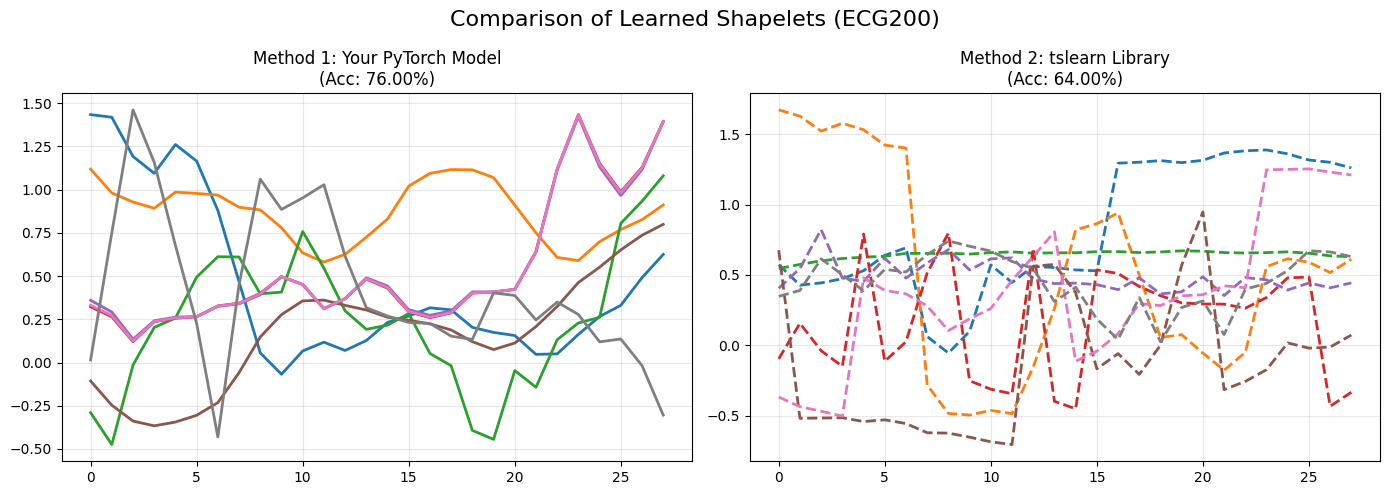

In [29]:
# -----------------------------------------------------------------------------
# 5. VISUALIZATION & COMPARISON
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot PyTorch
for i in range(K_SHAPELETS):
    axes[0].plot(pt_shapelets[i], linewidth=2, label=f'Shp {i+1}')
axes[0].set_title(f'Method 1: Your PyTorch Model\n(Acc: {pt_acc:.2%})')
axes[0].grid(True, alpha=0.3)

# Plot tslearn
for i in range(K_SHAPELETS):
    axes[1].plot(ts_shapelets[i], linewidth=2, linestyle='--', label=f'Shp {i+1}')
axes[1].set_title(f'Method 2: tslearn Library\n(Acc: {ts_acc:.2%})')
axes[1].grid(True, alpha=0.3)

plt.suptitle(f"Comparison of Learned Shapelets ({meta['dataset']})", fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
pt_shapelets.shape, ts_shapelets.shape

((8, 28), (8, 28))

In [31]:
def plot_shapelet_on_series(series, shapelets_dict, shapelet_index=0, title="Shapelet Analysis"):
    """
    Plots the best matching position of a specific shapelet (by index) 
    for multiple methods (provided in shapelets_dict) on the same series.
    
    Args:
        series (array): The time series data (1D).
        shapelets_dict (dict): Keys are method names (str), Values are arrays of shapelets.
                               e.g., {'tslearn': all_ts_shapelets, 'pytorch': all_pt_shapelets}
        shapelet_index (int): Which shapelet from the array to visualize (default 0).
    """
    series = series.ravel()
    n_methods = len(shapelets_dict)
    
    # Create subplots: 1 row per method
    fig, axes = plt.subplots(n_methods, 1, figsize=(12, 4 * n_methods), sharex=True)
    
    # Handle single-method case (axes is not a list if n=1)
    if n_methods == 1:
        axes = [axes]
        
    fig.suptitle(f"{title} - Comparing Shapelet #{shapelet_index+1}", fontsize=16)

    # Iterate over each method in the dictionary
    for ax, (method_name, shapelet_set) in zip(axes, shapelets_dict.items()):
        
        # 1. Select the specific shapelet
        # Check if shapelet_set is 2D (K shapelets) or 1D (single shapelet)
        shapelet_set = np.array(shapelet_set)
        if shapelet_set.ndim == 2:
            current_shapelet = shapelet_set[shapelet_index]
        else:
            current_shapelet = shapelet_set
            
        current_shapelet = current_shapelet.ravel()
        
        # 2. Find Best Match (Sliding Window)
        n_series = len(series)
        n_shapelet = len(current_shapelet)
        
        if n_shapelet > n_series:
            print(f"Warning: Shapelet ({n_shapelet}) longer than series ({n_series}) for {method_name}")
            continue

        distances = []
        # Calculate Euclidean distance at every possible start point
        for i in range(n_series - n_shapelet + 1):
            window = series[i : i + n_shapelet]
            dist = np.linalg.norm(window - current_shapelet)
            distances.append(dist)
            
        best_idx = np.argmin(distances)
        min_dist = distances[best_idx]
        
        # 3. Plotting
        # A. Plot full series
        ax.plot(series, color='black', alpha=0.5, linewidth=1, label="Time Series")
        
        # B. Plot the shapelet overlay
        t_range = np.arange(best_idx, best_idx + n_shapelet)
        ax.plot(t_range, current_shapelet, color='tab:red', linewidth=3, label=f"{method_name} Shapelet")
        
        # C. Highlight the matching window
        ax.axvspan(best_idx, best_idx + n_shapelet, color='tab:red', alpha=0.15)
        
        # Formatting
        ax.set_title(f"Method: {method_name} (Dist: {min_dist:.4f})")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)
        ax.set_ylabel("Amplitude")

    plt.xlabel("Time Step")
    plt.tight_layout()
    plt.show()


def plot_all_shapelets_grid(series, shapelets_dict, title="Shapelet Match Analysis"):
    """
    Plots a grid of matches: 
    - Rows: Different Methods (PyTorch, tslearn)
    - Cols: Individual Shapelets (1..K)
    """
    series = series.ravel()
    
    n_methods = len(shapelets_dict)
    # Determine K (number of shapelets) from the first method in the dict
    first_key = list(shapelets_dict.keys())[0]
    n_shapelets = shapelets_dict[first_key].shape[0]
    
    # Create Grid
    fig, axes = plt.subplots(n_methods, n_shapelets, 
                             figsize=(n_shapelets * 3, n_methods * 2.5), 
                             sharex=True, sharey=True)
    
    # Ensure axes is always 2D array [row, col] for consistent indexing
    if n_methods == 1 and n_shapelets == 1:
        axes = np.array([[axes]])
    elif n_methods == 1:
        axes = axes[np.newaxis, :] # 1 row, multiple cols
    elif n_shapelets == 1:
        axes = axes[:, np.newaxis] # Multiple rows, 1 col
        
    fig.suptitle(f"{title}\n(Red Region = Best Match Location)", fontsize=16, y=1.02)

    # Iterate Rows (Methods)
    for row_idx, (method_name, shapelets) in enumerate(shapelets_dict.items()):
        
        # Iterate Cols (Individual Shapelets)
        for col_idx in range(n_shapelets):
            ax = axes[row_idx, col_idx]
            shapelet = shapelets[col_idx].ravel()
            
            # --- 1. Find Best Match Logic ---
            n_series = len(series)
            n_shp = len(shapelet)
            
            distances = []
            for i in range(n_series - n_shp + 1):
                window = series[i : i + n_shp]
                dist = np.linalg.norm(window - shapelet)
                distances.append(dist)
            
            if len(distances) > 0:
                best_idx = np.argmin(distances)
            else:
                best_idx = 0

            # --- 2. Plotting ---
            # Grey background series
            ax.plot(series, color='gray', alpha=0.3, linewidth=1)
            
            # Red shapelet overlay
            t_range = np.arange(best_idx, best_idx + n_shp)
            ax.plot(t_range, shapelet, color='red', linewidth=2)
            
            # ADDED: Vertical Span Highlight
            ax.axvspan(best_idx, best_idx + n_shp, color='red', alpha=0.1)
            
            # Visuals
            if col_idx == 0:
                ax.set_ylabel(f"{method_name}", fontsize=12, fontweight='bold')
            
            if row_idx == 0:
                ax.set_title(f"Shapelet {col_idx+1}", fontsize=10)
                
            ax.grid(True, alpha=0.1)

    plt.tight_layout()
    plt.show()

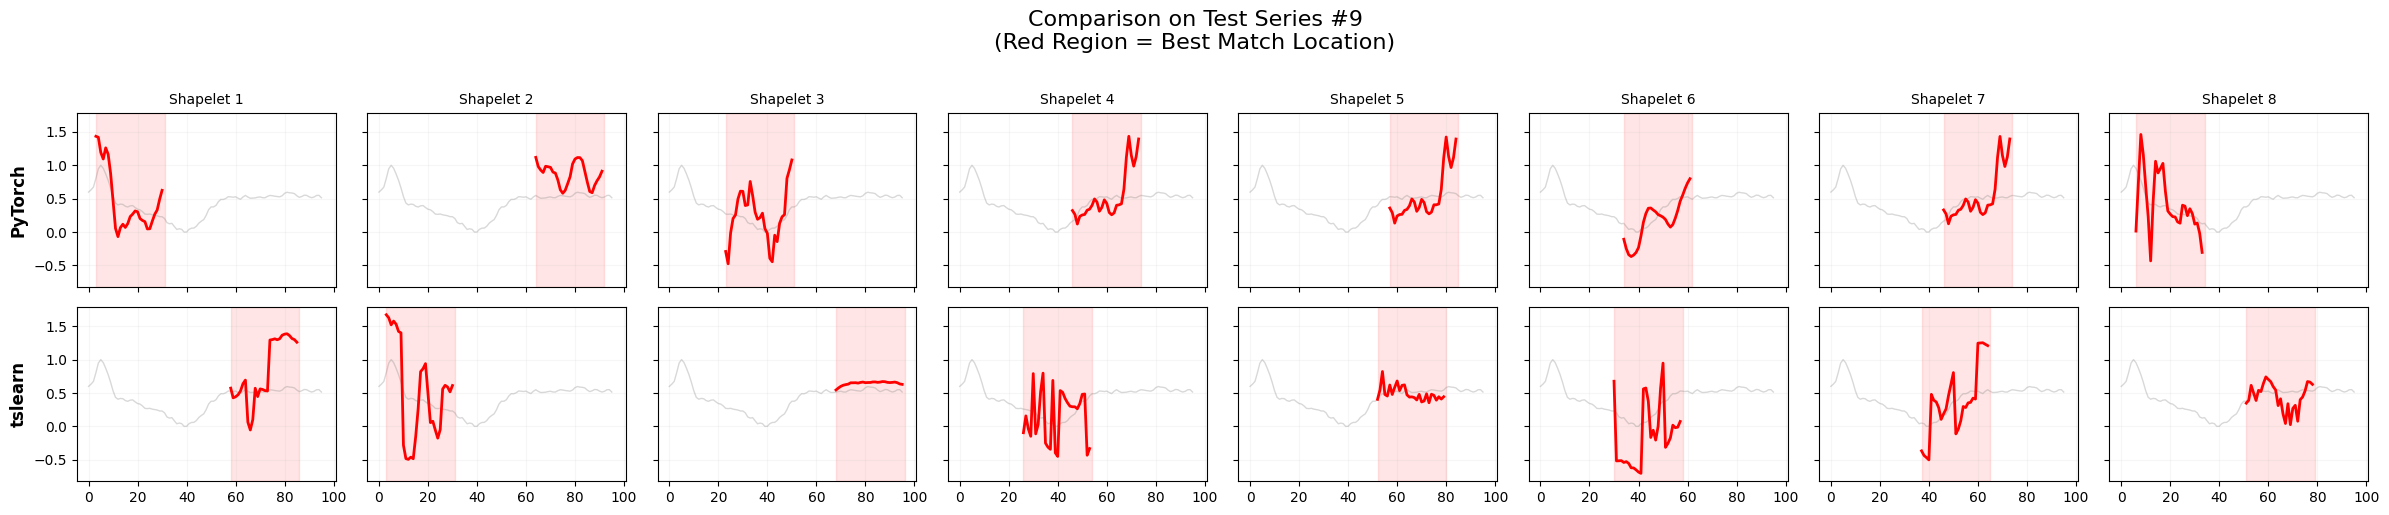

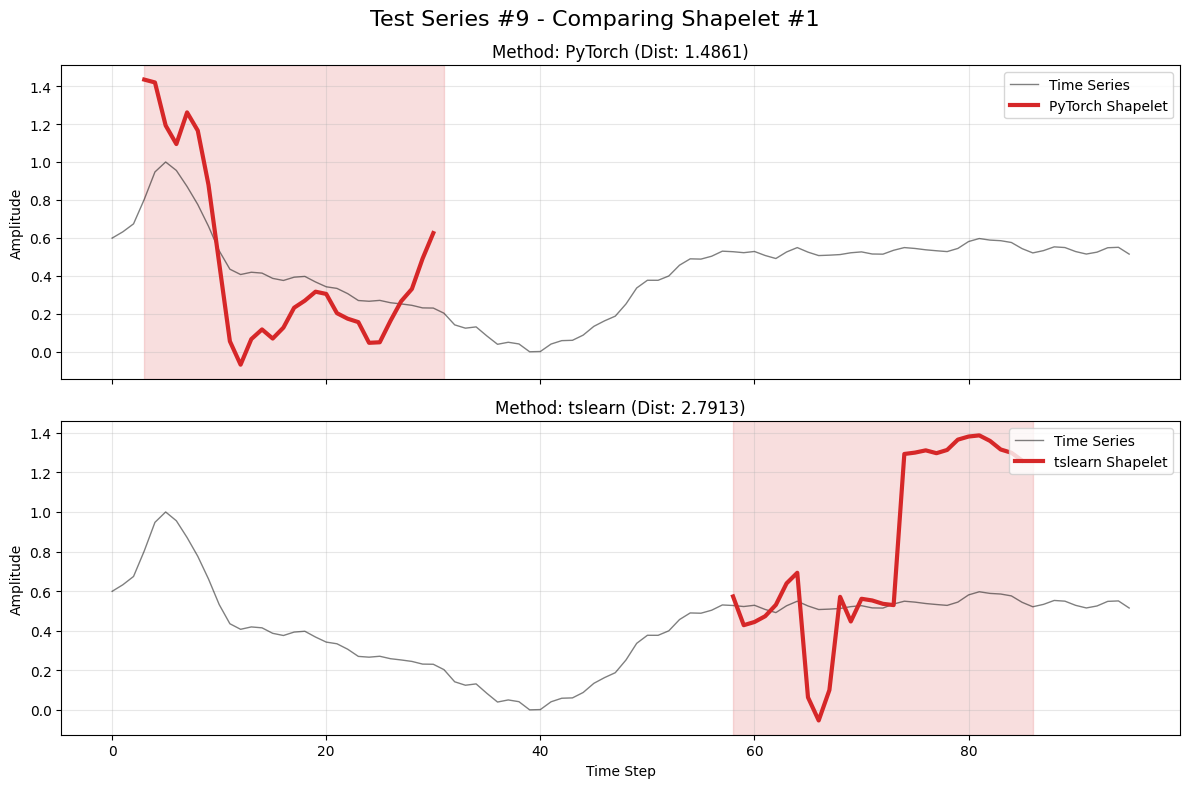

In [32]:

# --- EXECUTION ---
# Pick a random test series
sample_id = np.random.randint(0, X_test.shape[0])
series_data = X_test[sample_id]

# Define dictionary
shapelets_dict = {
    'PyTorch': pt_shapelets, # Shape: (K, L)
    'tslearn': ts_shapelets  # Shape: (K, L)
}

plot_all_shapelets_grid(series_data, shapelets_dict, title=f"Comparison on Test Series #{sample_id}")


# Visualize Shapelet at index 0 (First shapelet) for both models
plot_shapelet_on_series(series_data, shapelets_dict, shapelet_index=0, title=f"Test Series #{sample_id}")